In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3824655/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
WINDOW_SIZES = ["1d", "7d", "14d"]
MODEL_NAMES = ["all-MiniLM-L12-v2"]
ORG_NAME = "Aave - Aavegotchi"
SPLITS_FREQ = "5d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2023-05-01"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1081 non-null   object        
 1   author             1081 non-null   object        
 2   date               1081 non-null   datetime64[us]
 3   start              1081 non-null   datetime64[us]
 4   end                1081 non-null   datetime64[us]
 5   platform_proposal  1081 non-null   object        
dtypes: datetime64[us](3), object(3)
memory usage: 50.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328356 entries, 0 to 2328355
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   id        object        
 1   proposal  object        
 2   voter     object        
 3   date      datetime64[us]
dtypes: datetime64[us](1), object(3)
memory usage: 71.1+ MB
None
<class 'pandas.core.frame.DataFr

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Aave - Aavegotchi/baseline/folds-info_5d_normalize.parquet
fold
2023-05-31    2064666
2023-06-05    2073321
2023-06-10    2082848
2023-06-15    2089911
2023-06-20    2101656
2023-06-25    2111105
2023-06-30    2119054
2023-07-05    2131474
2023-07-10    2228463
2023-07-15    2311301
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W22,6,5301,1403,883.50,3.78,5237,2008,872.83,2.61
2023-W23,2,2256,2142,1128.00,1.05,445,442,222.50,1.01
2023-W23,5,5297,3136,1059.40,1.69,2724,1834,544.80,1.49
2023-W24,8,5485,2673,685.62,2.05,10058,3038,1257.25,3.31
2023-W25,4,1275,1030,318.75,1.24,5628,3354,1407.00,1.68
2023-W25,3,3171,2729,1057.00,1.16,1853,1529,617.67,1.21
2023-W26,11,7554,2789,686.73,2.71,8509,2177,773.55,3.91
2023-W27,4,3537,2424,884.25,1.46,26364,14173,6591.00,1.86
2023-W28,0,0,0,nan,nan,0,0,nan,nan


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W22 & 6 & 5301 & 1403 & 883.50 & 3.78 & 5237 & 2008 & 872.83 & 2.61 \\
2023-W23 & 2 & 2256 & 2142 & 1128.00 & 1.05 & 445 & 442 & 222.50 & 1.01 \\
2023-W23 & 5 & 5297 & 3136 & 1059.40 & 1.69 & 2724 & 1834 & 544.80 & 1.49 \\
2023-W24 & 8 & 5485 & 2673 & 685.62 & 2.05 & 10058 & 3038 & 1257.25 & 3.31 \\
2023-W25 & 4 & 1275 & 1030 & 318.75 & 1.24 & 5628 & 3354 & 1407.00 & 1.68 \\
2023-W25 & 3 & 3171 & 2729 & 1057.00 & 1.16 & 1853 & 1529 & 617.67 & 1.21 \\
2023-W26 & 11 & 7554 & 2789 & 686.73 & 2.71 & 8509 & 2177 & 773.55 & 3.91 \\
2023-W27 & 4 & 3537 & 2424 & 884.25 & 1.46 & 26364 & 14173 & 6591.00 & 1.86 \\
2023-W28 & 0 & 0 & 0 & nan & nan 

## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/263 [00:00<?, ?it/s]

Warning, empty test fold 0 (2019-12-13 00:00:00), all ok since 0 folds ago
Warning, empty test fold 1 (2019-12-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 2 (2019-12-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 3 (2019-12-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 4 (2020-01-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 5 (2020-01-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 6 (2020-01-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 7 (2020-01-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 8 (2020-01-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 9 (2020-01-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 10 (2020-02-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 11 (2020-02-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 12 (2020-02-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 13 (2020-02-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 14 (2020-02-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 15 (2020-02-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 16 (2020-03-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 17 (2020-03-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 18 (2020-03-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 19 (2020-03-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 20 (2020-03-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 21 (2020-03-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 22 (2020-04-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 23 (2020-04-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 24 (2020-04-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 25 (2020-04-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 26 (2020-04-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 27 (2020-04-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 28 (2020-05-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 29 (2020-05-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 30 (2020-05-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 31 (2020-05-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 32 (2020-05-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 33 (2020-05-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 34 (2020-05-31 00:00:00), all ok since 1 folds ago
Warning, empty test fold 35 (2020-06-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 36 (2020-06-10 00:00:00), all ok since 1 folds ago
Warning, empty test fold 37 (2020-06-15 00:00:00), all ok since 1 folds ago


Warning, test fold 38 (2020-06-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 39 (2020-06-25 00:00:00), all ok since 2 folds ago
Warning, empty test fold 40 (2020-06-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 41 (2020-07-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 42 (2020-07-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 43 (2020-07-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 44 (2020-07-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 45 (2020-07-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 46 (2020-07-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 47 (2020-08-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 48 (2020-08-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 49 (2020-08-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 50 (2020-08-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 51 (2020-08-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 52 (2020-08-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 53 (2020-09-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 54 (2020-09-08 00:00:00), all ok since 1 folds ago


Warning, empty test fold 55 (2020-09-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 56 (2020-09-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 57 (2020-09-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 58 (2020-09-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 59 (2020-10-03 00:00:00), all ok since 1 folds ago
Warning, test fold 60 (2020-10-08 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 61 (2020-10-13 00:00:00), all ok since 2 folds ago
Warning, empty test fold 62 (2020-10-18 00:00:00), all ok since 1 folds ago


Warning, test fold 63 (2020-10-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 64 (2020-10-28 00:00:00), all ok since 2 folds ago
Warning, empty test fold 65 (2020-11-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 66 (2020-11-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 67 (2020-11-12 00:00:00), all ok since 1 folds ago


Warning, test fold 68 (2020-11-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 69 (2020-11-22 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 70 (2020-11-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 71 (2020-12-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 72 (2020-12-07 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 73 (2020-12-12 00:00:00), all ok since 6 folds ago
Warning, empty test fold 74 (2020-12-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 75 (2020-12-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 76 (2020-12-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 77 (2021-01-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 78 (2021-01-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 79 (2021-01-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 80 (2021-01-16 00:00:00), all ok since 1 folds ago


Warning, test fold 81 (2021-01-21 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 82 (2021-01-26 00:00:00), all ok since 2 folds ago
Warning, empty test fold 83 (2021-01-31 00:00:00), all ok since 1 folds ago


Warning, empty test fold 84 (2021-02-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 85 (2021-02-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 86 (2021-02-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 87 (2021-02-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 88 (2021-02-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 89 (2021-03-02 00:00:00), all ok since 1 folds ago


Warning, test fold 112 (2021-06-25 00:00:00) with less than 5 open proposals (4). all ok since 23 folds ago


Warning, test fold 114 (2021-07-05 00:00:00) with less than 5 open proposals (3). all ok since 2 folds ago


Warning, test fold 115 (2021-07-10 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 124 (2021-08-24 00:00:00) with less than 5 open proposals (1). all ok since 9 folds ago


Warning, test fold 125 (2021-08-29 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 133 (2021-10-08 00:00:00) with less than 5 open proposals (3). all ok since 8 folds ago


Warning, test fold 134 (2021-10-13 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 135 (2021-10-18 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 136 (2021-10-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 137 (2021-10-28 00:00:00), all ok since 48 folds ago
Warning, test fold 138 (2021-11-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 139 (2021-11-07 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 140 (2021-11-12 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 142 (2021-11-22 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 143 (2021-11-27 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 144 (2021-12-02 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 148 (2021-12-22 00:00:00) with less than 5 open proposals (3). all ok since 4 folds ago


Warning, test fold 149 (2021-12-27 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 150 (2022-01-01 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 151 (2022-01-06 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 152 (2022-01-11 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 153 (2022-01-16 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 154 (2022-01-21 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 155 (2022-01-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 160 (2022-02-20 00:00:00) with less than 5 open proposals (3). all ok since 5 folds ago


Warning, empty test fold 161 (2022-02-25 00:00:00), all ok since 24 folds ago
Warning, test fold 162 (2022-03-02 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 163 (2022-03-07 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 164 (2022-03-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 165 (2022-03-17 00:00:00), all ok since 4 folds ago
Warning, test fold 166 (2022-03-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 168 (2022-04-01 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, test fold 169 (2022-04-06 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 170 (2022-04-11 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 171 (2022-04-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 172 (2022-04-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 173 (2022-04-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 174 (2022-05-01 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 175 (2022-05-06 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 176 (2022-05-11 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 177 (2022-05-16 00:00:00), all ok since 12 folds ago
Warning, test fold 178 (2022-05-21 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 179 (2022-05-26 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 180 (2022-05-31 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 184 (2022-06-20 00:00:00) with less than 5 open proposals (3). all ok since 4 folds ago


Warning, test fold 186 (2022-06-30 00:00:00) with less than 5 open proposals (3). all ok since 2 folds ago


Warning, empty test fold 187 (2022-07-05 00:00:00), all ok since 10 folds ago
Warning, test fold 188 (2022-07-10 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 189 (2022-07-15 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 190 (2022-07-20 00:00:00), all ok since 3 folds ago


Warning, test fold 191 (2022-07-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 193 (2022-08-04 00:00:00) with less than 5 open proposals (3). all ok since 2 folds ago


Warning, test fold 195 (2022-08-14 00:00:00) with less than 5 open proposals (3). all ok since 2 folds ago


Warning, test fold 197 (2022-08-24 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 199 (2022-09-03 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, test fold 200 (2022-09-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 201 (2022-09-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 202 (2022-09-18 00:00:00), all ok since 12 folds ago


Warning, test fold 203 (2022-09-23 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 204 (2022-09-28 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 205 (2022-10-03 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 207 (2022-10-13 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, test fold 209 (2022-10-23 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 210 (2022-10-28 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 213 (2022-11-12 00:00:00) with less than 5 open proposals (1). all ok since 3 folds ago


Warning, test fold 214 (2022-11-17 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 216 (2022-11-27 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 217 (2022-12-02 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 218 (2022-12-07 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 219 (2022-12-12 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 220 (2022-12-17 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 221 (2022-12-22 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 222 (2022-12-27 00:00:00), all ok since 20 folds ago


Warning, test fold 223 (2023-01-01 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 225 (2023-01-11 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 226 (2023-01-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 227 (2023-01-21 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 228 (2023-01-26 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 229 (2023-01-31 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 230 (2023-02-05 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 231 (2023-02-10 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 235 (2023-03-02 00:00:00) with less than 5 open proposals (2). all ok since 4 folds ago


Warning, test fold 236 (2023-03-07 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 246 (2023-04-26 00:00:00) with less than 5 open proposals (4). all ok since 10 folds ago


Warning, test fold 249 (2023-05-11 00:00:00) with less than 5 open proposals (4). all ok since 3 folds ago


Warning, test fold 252 (2023-05-26 00:00:00) with less than 5 open proposals (4). all ok since 3 folds ago


Warning, test fold 254 (2023-06-05 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, test fold 257 (2023-06-20 00:00:00) with less than 5 open proposals (4). all ok since 3 folds ago


Warning, test fold 258 (2023-06-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 260 (2023-07-05 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, empty test fold 261 (2023-07-10 00:00:00), all ok since 39 folds ago


Max ok in a row: (48, Timestamp('2021-10-28 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Aave - Aavegotchi/baseline/openpop_5d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,...,263.000000,263.000000,263.000000,263.000000,262.000000,262.000000,262.000000,262.000000,262.000000,263.000000
mean,0.342167,0.241610,0.185869,0.107349,0.073556,0.011091,0.341370,0.433022,0.471549,0.492691,...,0.627409,0.637804,0.639640,0.452344,0.518844,0.539878,0.546104,0.546576,0.546625,0.399813
std,0.354296,0.205735,0.161228,0.097412,0.067937,0.010280,0.353500,0.381461,0.388041,0.388850,...,0.467048,0.470627,0.471692,0.387363,0.411119,0.418112,0.418670,0.418701,0.418701,0.862810
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067465
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069678
50%,0.244604,0.328676,0.203556,0.105287,0.070425,0.010564,0.244604,0.453065,0.552100,0.614442,...,1.000000,1.000000,1.000000,0.470668,0.610078,0.679015,0.686908,0.690911,0.691722,0.171493
75%,0.616912,0.381786,0.292647,0.166131,0.114017,0.017103,0.616912,0.785555,0.820169,0.821097,...,1.000000,1.000000,1.000000,0.840646,0.931646,0.951915,0.951915,0.951915,0.951915,0.347719
max,1.000000,0.961636,0.953529,0.476764,0.346093,0.051914,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.501266


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Aave - Aavegotchi/baseline/perfect_5d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,...,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,0.657795,0.335419,0.220190,0.113523,0.075906,0.011389,0.657795,0.657795,0.657795,0.657795,...,0.657530,0.657778,0.657795,0.512787,0.634931,0.653300,0.657530,0.657778,0.657795,0.420420
std,0.475353,0.273626,0.194464,0.103651,0.069514,0.010432,0.475353,0.475353,0.475353,0.475353,...,0.475163,0.475340,0.475353,0.400529,0.461749,0.472380,0.475163,0.475340,0.475353,0.919317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071303
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073206
50%,1.000000,0.359763,0.216949,0.108475,0.072316,0.010847,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.634432,0.948662,0.997076,1.000000,1.000000,1.000000,0.176701
75%,1.000000,0.546110,0.351864,0.176747,0.117831,0.017675,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.877207,1.000000,1.000000,1.000000,1.000000,1.000000,0.345829
max,1.000000,0.968151,0.953529,0.509020,0.346093,0.051914,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.390668


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,263,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,...,263.000000,263.000000,262.000000,262.000000,262.000000,262.000000,262.000000,263.000000,0.0,0.0
mean,2021-09-28 00:00:00,0.342167,0.241610,0.185869,0.107349,0.073556,0.011091,0.341370,0.433022,0.471549,...,0.639640,0.452344,0.518844,0.539878,0.546104,0.546576,0.546625,0.399813,NaN,NaN
min,2019-12-13 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067465,NaN,NaN
25%,2020-11-04 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069678,NaN,NaN
50%,2021-09-28 00:00:00,0.244604,0.328676,0.203556,0.105287,0.070425,0.010564,0.244604,0.453065,0.552100,...,1.000000,0.470668,0.610078,0.679015,0.686908,0.690911,0.691722,0.171493,NaN,NaN
75%,2022-08-21 12:00:00,0.616912,0.381786,0.292647,0.166131,0.114017,0.017103,0.616912,0.785555,0.820169,...,1.000000,0.840646,0.931646,0.951915,0.951915,0.951915,0.951915,0.347719,NaN,NaN
max,2023-07-15 00:00:00,1.000000,0.961636,0.953529,0.476764,0.346093,0.051914,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.501266,NaN,NaN
std,NaN,0.354296,0.205735,0.161228,0.097412,0.067937,0.010280,0.353500,0.381461,0.388041,...,0.471692,0.387363,0.411119,0.418112,0.418670,0.418701,0.418701,0.862810,NaN,NaN


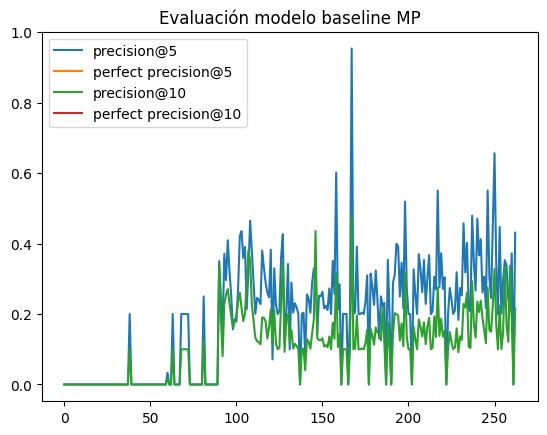

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0
mean,2023-06-22 12:00:00,0.317190,0.317816,0.288777,0.183101,0.125662,0.018849,0.315270,0.450517,0.545863,...,0.859696,0.511116,0.603722,0.665269,0.669817,0.669817,0.669817,0.818719,NaN,NaN
min,2023-05-31 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069665,NaN,NaN
25%,2023-06-11 06:00:00,0.138032,0.248221,0.217416,0.128025,0.085350,0.012802,0.138032,0.281046,0.447367,...,1.000000,0.354941,0.463679,0.531660,0.575494,0.575494,0.575494,0.405773,NaN,NaN
50%,2023-06-22 12:00:00,0.274652,0.324022,0.316327,0.176908,0.117938,0.017691,0.274652,0.533788,0.611794,...,1.000000,0.522883,0.632637,0.640868,0.640868,0.640868,0.640868,0.486306,NaN,NaN
75%,2023-07-03 18:00:00,0.436515,0.395800,0.367190,0.221430,0.147620,0.022143,0.436515,0.644431,0.727951,...,1.000000,0.690470,0.800210,0.885367,0.885367,0.885367,0.885367,0.841969,NaN,NaN
max,2023-07-15 00:00:00,0.850420,0.559275,0.446931,0.336932,0.260573,0.039086,0.850420,0.737810,0.820263,...,1.000000,0.988281,1.000000,1.000000,1.000000,1.000000,1.000000,3.529701,NaN,NaN
std,NaN,0.254062,0.156695,0.132477,0.102099,0.074710,0.011206,0.252101,0.240445,0.259633,...,0.327548,0.284841,0.304000,0.299615,0.297131,0.297131,0.297131,0.998635,NaN,NaN
